In [2]:
import cv2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from core.utils import IoU, assemble_data, convert_to_square
from core.models import creat_mtcnn_net
from core.utils import generate_bounding_box, nms
from core.detect import detect_pnet, detect_rnet

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
anno_file = '/Users/shaotianyuan/DATA/WIDER/wider_face_split/wider_face_train_bbx_gt.txt'
im_dir = '/Users/shaotianyuan/DATA/WIDER/WIDER_train/images'

pos_save_dir = './data_set/train/48/positive'
part_save_dir = './data_set/train/48/part'
neg_save_dir = './data_set/train/48/negative'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.mkdir(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.mkdir(neg_save_dir)
    
f1 = open(os.path.join('./anno_store', 'pos_48.txt'), 'w')
f2 = open(os.path.join('./anno_store', 'neg_48.txt'), 'w')
f3 = open(os.path.join('./anno_store', 'part_48.txt'), 'w')


p_idx = 0
n_idx = 0
d_idx = 0
image_idx = 0
box_idx = 0

pnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/pnet.pkl'
rnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/rnet.pkl'

In [7]:
with open(anno_file) as f:
    annotations = f.readlines()

n = -1
lines = []
for annotation in annotations:
    annotation = annotation.strip().split(' ')
    if annotation[0][-3:] == 'jpg':
        lines.append(annotation)
        n += 1
    else:
        annotation = list(map(int, annotation))
        lines[n].extend(annotation[:4])
print(len(lines))
print(lines[:2])

12880
[['0--Parade/0_Parade_marchingband_1_849.jpg', 1, 449, 330, 122, 149], ['0--Parade/0_Parade_Parade_0_904.jpg', 1, 361, 98, 263, 339]]


In [8]:
for annotation in lines[:200]:
    im_path = os.path.join(im_dir, annotation[0])
    bbox = list(map(float, annotation[2:]))
    boxes = np.array(bbox, dtype=np.int32).reshape(-1, 4)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    
    img = np.array(Image.open(im_path).convert('RGB'))
    gts = boxes
    _, p_boxes_align = detect_pnet(img, pnet_path)
    _, dets = detect_rnet(img, p_boxes_align, rnet_path)
    
    image_idx += 1
    if image_idx % 10 == 0:
        print(image_idx, "images done")
    
    if dets is None or dets.shape[0] == 0:
        continue
  
    dets = convert_to_square(dets)
    dets[:, :4] = np.round(dets[:, :4])
    
    neg_num = 0
    
    for box in dets:
        x_left, y_top, x_right, y_bottom, _ = box.astype(int)
        width = x_right - x_left + 1
        height = y_bottom - y_top + 1
        
        if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
            continue
            
        Iou = IoU(box, gts)
        cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
        resized_im = cv2.resize(cropped_im, (48, 48), interpolation=cv2.INTER_LINEAR)
        
        if np.max(Iou) < 0.3 and neg_num < 60:
            # save the examples
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            # print(save_file)
            f2.write(save_file + ' 0 %.2f %.2f %.2f %.2f\n' % (0, 0, 0, 0))
            img_save = Image.fromarray(resized_im)
            img_save.save(save_file)
            n_idx += 1
            neg_num += 1
        else:
            # find gt_box with the highest iou
            idx = np.argmax(Iou)
            x1, y1, x2, y2 = gts[idx]

            # compute bbox reg label
            offset_x1 = (x1 - x_left) / float(width)
            offset_y1 = (y1 - y_top) / float(height)
            offset_x2 = (x2 - x_right) / float(width)
            offset_y2 = (y2 - y_bottom) / float(height)

            # save positive and part-face images and write labels
            if np.max(Iou) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                img_save = Image.fromarray(resized_im)
                img_save.save(save_file)
                p_idx += 1

            elif np.max(Iou) >= 0.4:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                img_save = Image.fromarray(resized_im)
                img_save.save(save_file)
                d_idx += 1
f1.close()
f2.close()
f3.close()
print()
print("%s images done, pos: %s part: %s neg: %s" % (image_idx, p_idx, d_idx, n_idx))

10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
70 images done
80 images done
90 images done
100 images done
110 images done
120 images done
130 images done
140 images done
150 images done
160 images done
170 images done
180 images done
190 images done
200 images done

200 images done, pos: 2589 part: 5454 neg: 8883


In [9]:
anno_list = ['./anno_store/neg_48.txt', './anno_store/part_48.txt', './anno_store/pos_48.txt']
imglist_filename = './anno_store/imglist_anno_48.txt'
chose_count = assemble_data(imglist_filename, anno_list)
chose_count

./anno_store/neg_48.txt
./anno_store/part_48.txt
./anno_store/pos_48.txt


16926

In [10]:
celeba_img_path = '/Users/shaotianyuan/DATA/CelebA/img_celeba/img_celeba'

landmark_file = '/Users/shaotianyuan/DATA/CelebA/list_landmarks_celeba.txt'
boxes_file = '/Users/shaotianyuan/DATA/CelebA/list_bbox_celeba.txt'

anno_save = './anno_store/landmark_48.txt'
traindata_save = './data_set/train/48/landmark'

if not os.path.exists(traindata_save):
    os.makedirs(traindata_save)

f = open(anno_save, 'w')

with open(landmark_file, 'r') as f1:
    landmark_lines = f1.readlines()
landmark_lines.pop(0)
landmark_lines.pop(0)

with open(boxes_file, 'r') as f2:
    boxes_lines = f2.readlines()
boxes_lines.pop(0)
boxes_lines.pop(0)
    
idx = 0
l_idx = 0

for i in range(5000):
    boxes = boxes_lines[i].strip().split(' ')
    landmarks = landmark_lines[i].strip().split(' ')
        
    lines = boxes + landmarks[1:]
    lines = [i for i in lines if i]
    
    img_path = os.path.join(celeba_img_path, lines[0])
    img = cv2.imread(img_path)
    height, width, channel = img.shape
    
    gt_box = np.array(lines[1: 5], dtype=np.int32)
    x1, y1, w, h = gt_box
    x2 = x1 + w - 1
    y2 = y1 + h - 1
    
    if max(w, h) < 40 or x1 < 0 or y1 < 0:
        continue
    
    
    landmark = np.array(lines[5: ], dtype=np.float).reshape(-1, 2)

    
    idx += 1
    if idx % 100 == 0:
        print("%d images done, landmark images: %d"%(idx,l_idx))

    for i in range(10):
        bbox_size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))
        delta_x = np.random.randint(-w * 0.2, w * 0.2)
        delta_y = np.random.randint(-h * 0.2, h * 0.2)
        
        nx1 = max(x1 + w / 2 - bbox_size / 2 + delta_x, 0)
        ny1 = max(y1 + h / 2 - bbox_size / 2 + delta_y, 0)
        nx2 = nx1 + bbox_size
        ny2 = ny1 + bbox_size
        if nx2 > width or ny2 > height:
            continue
            
        crop_box = np.array([nx1, ny1, nx2, ny2])
        cropped_im = img[int(ny1):int(ny2) + 1, int(nx1):int(nx2) + 1, :]
        resized_im = cv2.resize(cropped_im, (48, 48),interpolation=cv2.INTER_LINEAR)
        
        offset_res = np.around(([x1, y1, x2, y2] - crop_box) / float(bbox_size), 3)
        landmark_res = np.around((landmark - [nx1, ny1]) / float(bbox_size), 3)
        
        

        iou = IoU(crop_box, np.array([[x1, y1, x2, y2]]))
        
        if iou > 0.65:
            save_file = os.path.join(traindata_save, "%s.jpg" % l_idx)
            cv2.imwrite(save_file, resized_im)

            anno = [save_file] + [-2] + list(offset_res) + list(landmark_res.ravel()) + ['\n']
            anno = ' '.join([str(i) for i in anno])
            f.writelines(anno)
            l_idx += 1


print()
print("%d images done, landmark images: %d"%(idx,l_idx))
f.close()
    



100 images done, landmark images: 193
200 images done, landmark images: 377
300 images done, landmark images: 590
400 images done, landmark images: 792
500 images done, landmark images: 978
600 images done, landmark images: 1195
700 images done, landmark images: 1379
800 images done, landmark images: 1572
900 images done, landmark images: 1762
1000 images done, landmark images: 1971
1100 images done, landmark images: 2174
1200 images done, landmark images: 2362
1300 images done, landmark images: 2583
1400 images done, landmark images: 2782
1500 images done, landmark images: 2982
1600 images done, landmark images: 3196
1700 images done, landmark images: 3401
1800 images done, landmark images: 3597
1900 images done, landmark images: 3793
2000 images done, landmark images: 3987
2100 images done, landmark images: 4173
2200 images done, landmark images: 4391
2300 images done, landmark images: 4595
2400 images done, landmark images: 4776
2500 images done, landmark images: 4975
2600 images do

In [11]:
anno_list = ['./anno_store/neg_48.txt', './anno_store/part_48.txt', './anno_store/pos_48.txt', './anno_store/landmark_48.txt']
imglist_filename = './anno_store/imglist_anno_48.txt'
chose_count = assemble_data(imglist_filename, anno_list)
chose_count

./anno_store/neg_48.txt
./anno_store/part_48.txt
./anno_store/pos_48.txt
./anno_store/landmark_48.txt


26804

NameError: name 'lines' is not defined

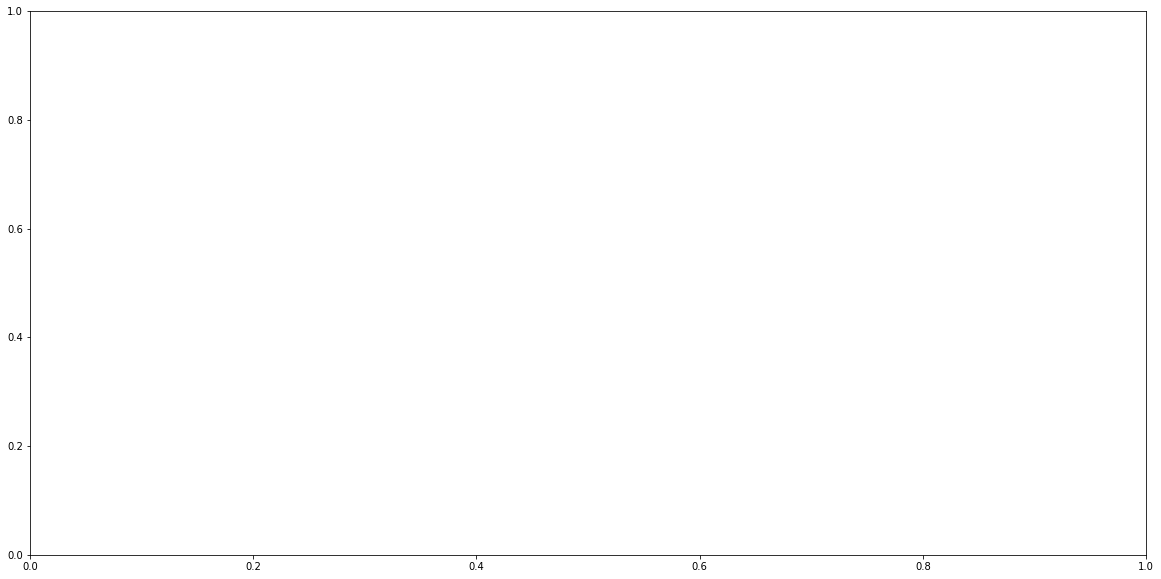

In [3]:
fig, ax = plt.subplots(figsize=(20,10))
landmarks_X = list(map(int, lines[5::2]))
landmarks_Y = list(map(int, lines[6::2]))
img = np.array(Image.open(img_path))
      
ax.imshow(img)
ax.scatter(landmarks_X, landmarks_Y, s=10, marker='.', c='r')
x1, y1, x2, y2 = gt_box       
rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
